# Packages

The cell below contains the packages that are used in the code.

In [1]:
from mesa.batchrunner import BatchRunner
from IconicityModel import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# BatchRunner

## Helper functions

Runs the batchrunner for a certain amount of episodes and steps.

In [2]:
def run_batchrunner(model, fixed_pm, variable_pm, nb_iterations, nb_steps):
    batch_run = BatchRunner(model,
                           variable_pm,
                           fixed_pm,
                           iterations = nb_iterations,
                           max_steps = nb_steps,
                           model_reporters = {"Data Collector": lambda m: m.datacollector})
    batch_run.run_all()
    return batch_run.get_model_vars_dataframe()

In [3]:
def calculate_average_agent_data_per_iteration(data, pm_values, nb_iterations):
    avg_data_per_pm = []
    max_data_per_pm = []
    min_data_per_pm = []
    
    for i in range(0, nb_iterations * len(pm_values), nb_iterations):
        iteration_df = data[i:i + nb_iterations]
        data_collector_dfs = [dc.get_model_vars_dataframe() for dc in iteration_df["Data Collector"].tolist()]
        
        avg_data_per_iteration = pd.concat(data_collector_dfs).groupby(level=0).mean()
        max_data_per_iteration = pd.concat(data_collector_dfs).groupby(level=0).max()
        min_data_per_iteration = pd.concat(data_collector_dfs).groupby(level=0).min()
        
        avg_data_per_pm.append(avg_data_per_iteration)
        max_data_per_pm.append(max_data_per_iteration)
        min_data_per_pm.append(min_data_per_iteration)
        
    
    return avg_data_per_pm, max_data_per_pm, min_data_per_pm

In [23]:
def plot_per_step_data(avg_data, max_data, min_data, pm_values, pm_name):
    l1_means = []
    l2_means = []
    total_means = []
    l1_maxs = []
    l2_maxs = []
    total_maxs = []
    l1_mins = []
    l2_mins = []
    total_mins = []
    
    # draw the agent data per step for each parameter value
    for i in range(len(pm_values)):
        fig, ax = plt.subplots(figsize=(16, 4))
        pm_value = pm_values[i]
        pm_data = avg_data[i]
        
        # L1 avg iconicity
        y_avg = avg_data[i]["l1_avg_iconicity"].to_numpy()
        y_max = max_data[i]["l1_avg_iconicity"].to_numpy()
        y_min = min_data[i]["l1_avg_iconicity"].to_numpy()
        x = np.arange(len(y_avg))
        
        ax.plot(x, y_avg, color='green', label='L1 avg. iconicity level', linewidth = 1.0)
        ax.fill_between(x, y_min, y_max, color='green', alpha=0.2)
        
        # Store end (last step) results for 2nd plot | index -1 is last element of array
        l1_means.append(y_avg[-1])
        l1_maxs.append(y_max[-1])
        l1_mins.append(y_min[-1])
        
        # L2 avg iconicity
        y_avg = avg_data[i]["l2_avg_iconicity"].to_numpy()
        y_max = max_data[i]["l2_avg_iconicity"].to_numpy()
        y_min = min_data[i]["l2_avg_iconicity"].to_numpy()
        
        ax.plot(x, y_avg, color='red', label='L2 avg. iconicity level', linewidth = 1.0)
        ax.fill_between(x, y_min, y_max, color='red', alpha=0.2)
        
        # Store end (last step) results for 2nd plot | index -1 is last element of array
        l2_means.append(y_avg[-1])
        l2_maxs.append(y_max[-1])
        l2_mins.append(y_min[-1])
        
        # Total avg iconicity
        y_avg = avg_data[i]["total_avg_iconicity"].to_numpy()
        y_max = max_data[i]["total_avg_iconicity"].to_numpy()
        y_min = min_data[i]["total_avg_iconicity"].to_numpy()
        
        ax.plot(x, y_avg, color='black', label='Total avg. iconicity level', linewidth = 1.0)
        ax.fill_between(x, y_min, y_max, color='black', alpha=0.2)
        
        # Store end (last step) results for 2nd plot | index -1 is last element of array
        total_means.append(y_avg[-1])
        total_maxs.append(y_max[-1])
        total_mins.append(y_min[-1])
        
        # General plot properties
        ax.grid(b=True, axis='both')
        ax.set_ylim([0,100])
        ax.set_xlim([0,len(x)-1])
        ax.set_xticks(range(len(x)))
        ax.set_title("Average iconicity level for " + str(pm_name) + " = " + str(pm_value))
        ax.set_ylabel("Average iconicity level")
        ax.set_xlabel("Steps")
        
    labels = ["L1 signers", "L2 signers", "all signers"]
    end_results = [[l1_means, l1_maxs, l1_mins], [l2_means, l2_maxs, l2_mins], [total_means, total_maxs, total_mins]]
             
    # draw the model results for each parameter value
    for i in range(3):
        plt.figure(i)
        x = np.asarray(pm_values)
        
        y = end_results[i]
        y_mean = np.asarray(y[0])
        y_max = np.asarray(y[1])
        y_min = np.asarray(y[2])
        
        plt.errorbar(x, y_mean,
                        yerr=[y_mean - y_min, y_max - y_mean],
                        uplims=True,
                        lolims=True,
                        fmt='.k',
                        ecolor='red',
                        lw=1)
        plt.bar(x, y_mean, width=8)
    
        plt.xticks(x)
        plt.yticks(np.arange(0, 120, 20))
    
        plt.title("Resulting avg. iconicity level for " + labels[i])
        plt.xlabel(pm_name)
        plt.ylabel("Average iconicity level")
    
        plt.show()

## Parameter exploration

### L2 replace chance

First we try several proportions for the replacement policy. Each value represents the chance of an agent being replaced by an L2 agent.

In [25]:
# define the values of the variable pm and amount of iterations and steps per iteration
proportions = [25, 50, 75]
nb_iterations = 10
nb_steps = 100

# define the fixed and variable parameters
fixed_pm = {"width": 10,
            "height": 10,
            "vocab_size": 10, 
            "word_length": 5,
            "turnover_chance": 20,
            "turnover_threshold": 10,
            "initial_degree_of_iconicity": 100,
            "learning_error_degree": 20,
            "l2_radius": 100}
variable_pm = {"l2_replace_chance": proportions}

# run the batchrunner
df = run_batchrunner(IconicityModel, fixed_pm, variable_pm, nb_iterations, nb_steps)

# print the statistics
print("STATISTICS FOR L2 REPLACEMENT CHANCE PARAMETER EXPLORATION")
print(" - Possible values: " + str(proportions))
print(" - Ran for " + str(nb_iterations) + " iteration(s) and " + str(nb_steps) + " steps per iteration")
print(" - Data from running the model for " + str(nb_iterations) + " iteration(s) for each parameter value:")

3it [04:42, 94.31s/it]

STATISTICS FOR L2 REPLACEMENT CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 1 iteration(s) and 50 steps per iteration
 - Data from running the model for 1 iteration(s) for each parameter value:


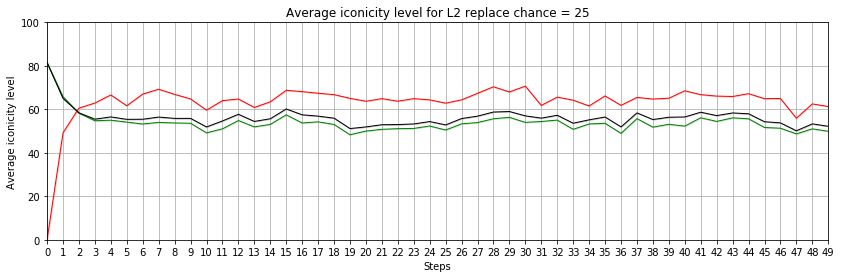

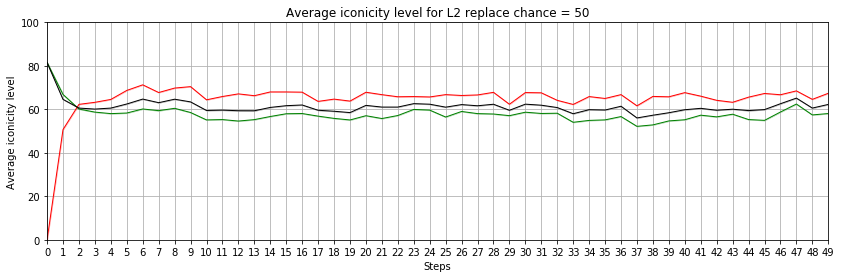

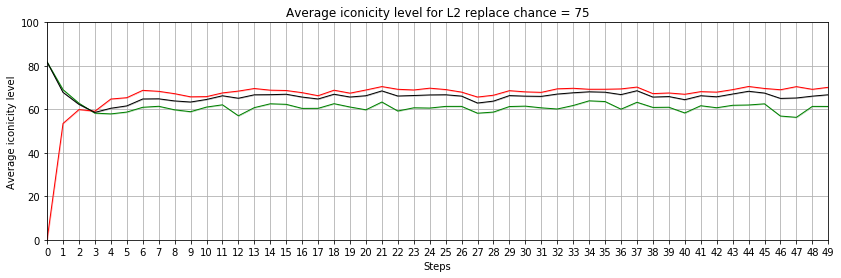

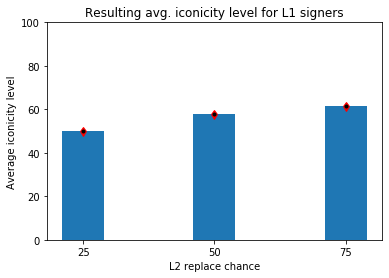

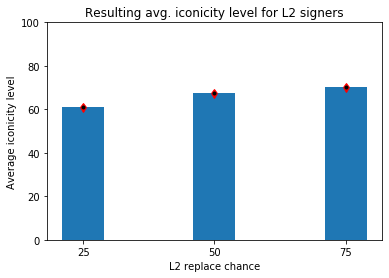

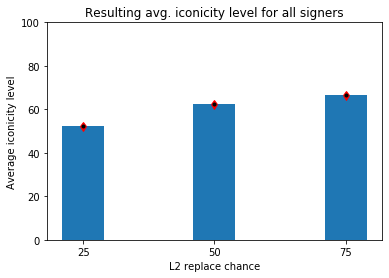

In [26]:
avg, maxi, mini = calculate_average_agent_data_per_iteration(df, proportions, nb_iterations)
plot_per_step_data(avg, maxi, mini, proportions, "L2 replace chance")

### L2 radius

Then we try several radiuses from which an L2 learner can acquire signs from.

In [7]:
# define the values of the variable pm and amount of iterations and steps per iteration
radiuses = [1, 25, 50, 75, 100]
nb_iterations = 10
nb_steps = 100

# define the fixed and variable parameters
fixed_pm = {"width": 10,
            "height": 10,
            "vocab_size": 10,
            "word_length": 5,
            "turnover_chance": 20,
            "turnover_threshold": 10,
            "initial_degree_of_iconicity": 100,
            "learning_error_degree": 20,
            "l2_replace_chance": 50}
variable_pm = {"l2_radius": radiuses}

# run the batchrunner
df = run_batchrunner(IconicityModel, fixed_pm, variable_pm, nb_iterations, nb_steps)

# print the statistics
print("STATISTICS FOR L2 LEARNING RADIUS PARAMETER EXPLORATION")
print(" - Possible values: " + str(radiuses))
print(" - Ran for " + str(nb_iterations) + " iteration(s) and " + str(nb_steps) + " steps per iteration\n")
print(" - Data from running the model for " + str(nb_iterations) + " iteration(s) for each parameter value:")

15it [00:21,  1.43s/it]

STATISTICS FOR L2 LEARNING RADIUS PARAMETER EXPLORATION
 - Possible values: [1, 25, 50, 75, 100]
 - Ran for 3 iteration(s) and 5 steps per iteration

 - Data from running the model for 3 iteration(s) for each parameter value:


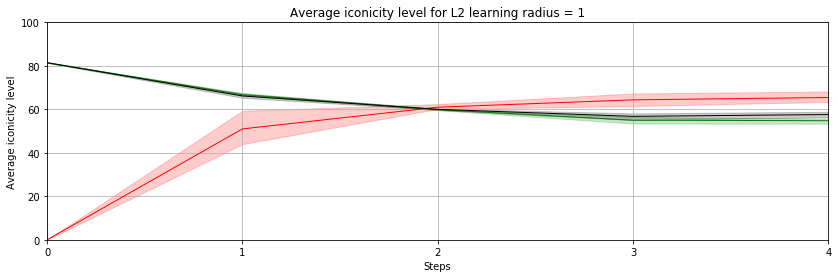

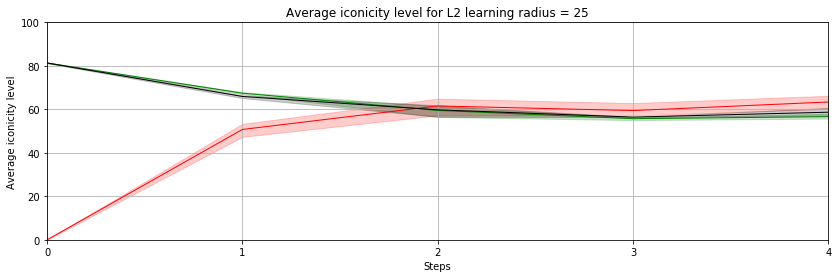

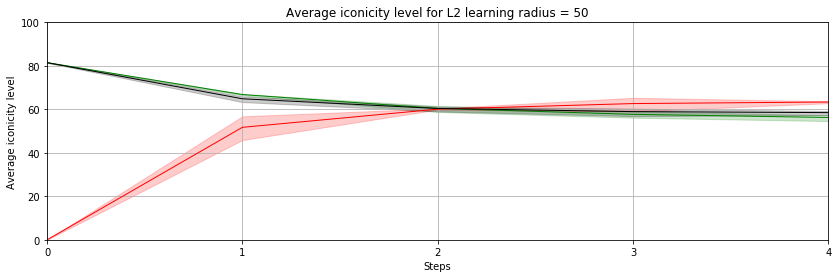

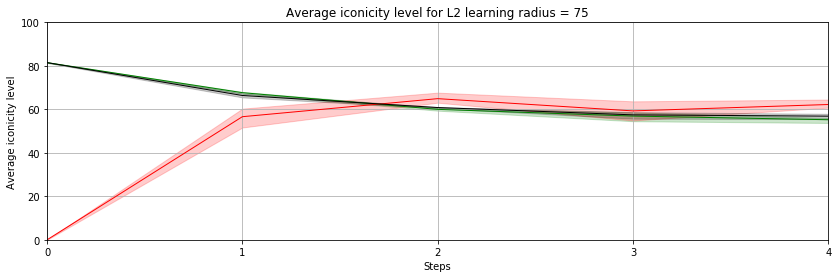

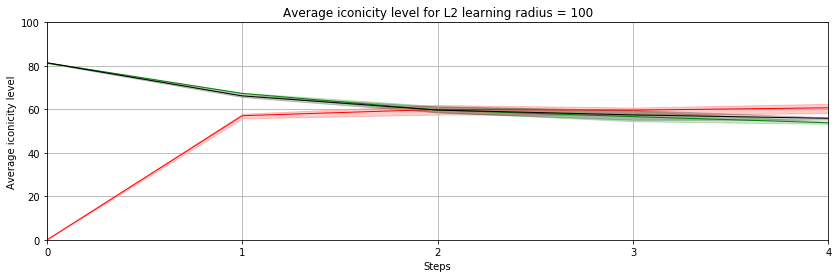

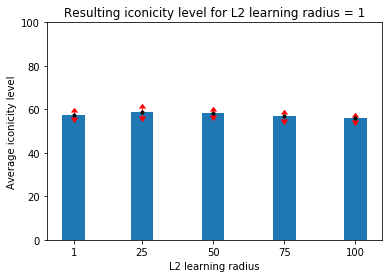

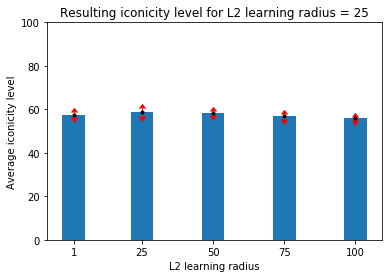

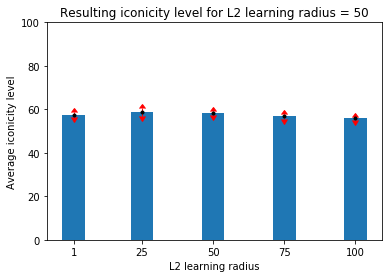

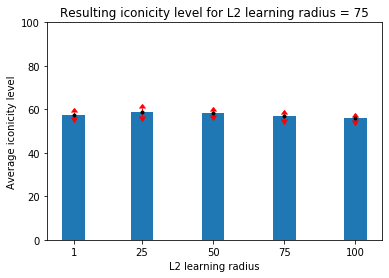

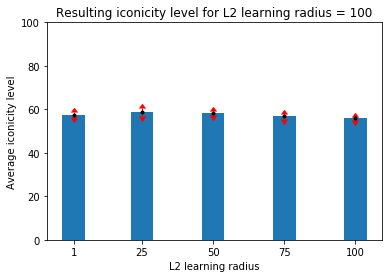

In [8]:
avg, maxi, mini = calculate_average_agent_data_per_iteration(df, radiuses, nb_iterations)
plot_per_step_data(avg, maxi, mini, radiuses, "L2 learning radius")

### Turnover chance

Then we try the turnover chance of the agents. This will determine the chance of an agent dying when it has reached age 2 or higher.

In [9]:
# define the values of the variable pm and amount of iterations and steps per iteration
chances = [10, 30, 50, 70, 90]
nb_iterations = 10
nb_steps = 100

# define the fixed and variable parameters
fixed_pm = {"width": 10,
            "height": 10,
            "vocab_size": 10,
            "word_length": 5,
            "turnover_threshold": 10,
            "initial_degree_of_iconicity": 100,
            "learning_error_degree": 20,
            "l2_radius": 100,
            "l2_replace_chance": 50}
variable_pm = {"turnover_chance": chances}

# run the batchrunner
df = run_batchrunner(IconicityModel, fixed_pm, variable_pm, nb_iterations, nb_steps)

# print the statistics
print("STATISTICS FOR TURNOVER CHANCE PARAMETER EXPLORATION")
print(" - Possible values: " + str(chances))
print(" - Ran for " + str(nb_iterations) + " iteration(s) and " + str(nb_steps) + " steps per iteration\n")
print(" - Data from running the model for " + str(nb_iterations) + " iteration(s) for each parameter value:")

15it [01:21,  5.40s/it]

STATISTICS FOR TURNOVER CHANCE PARAMETER EXPLORATION
 - Possible values: [10, 30, 50, 70, 90]
 - Ran for 3 iteration(s) and 5 steps per iteration

 - Data from running the model for 3 iteration(s) for each parameter value:


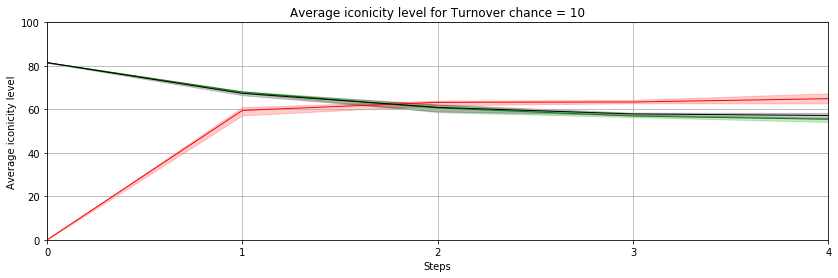

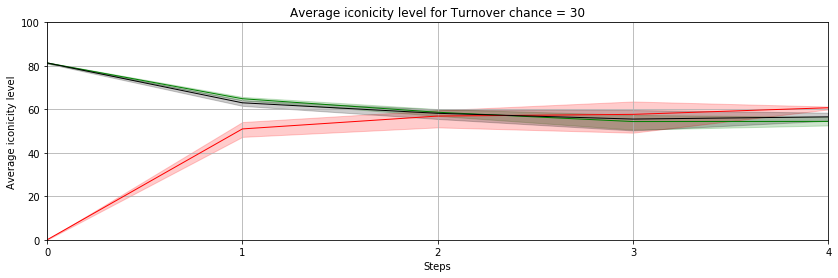

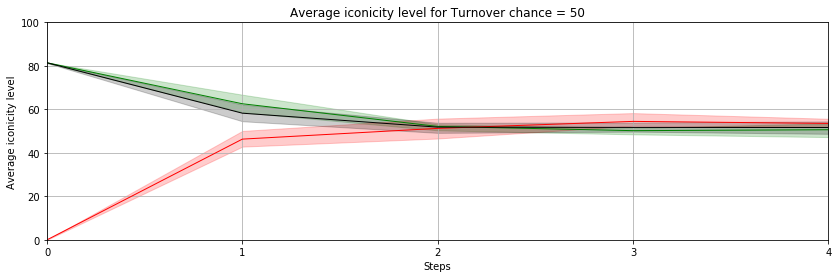

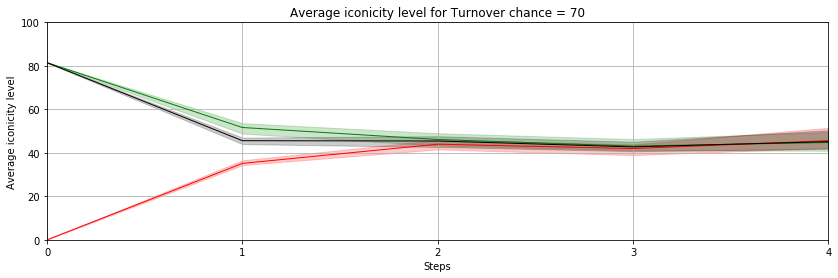

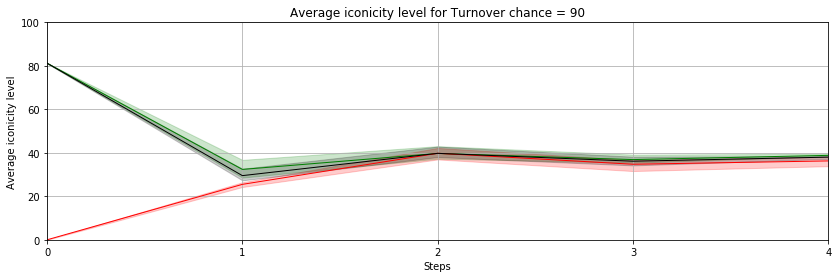

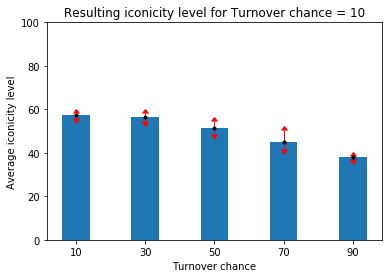

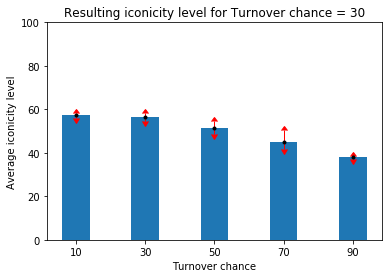

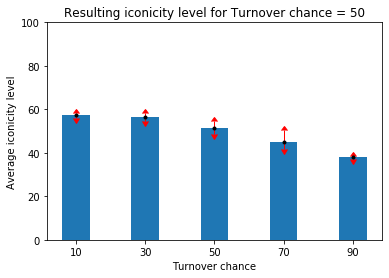

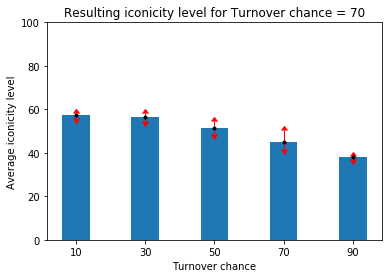

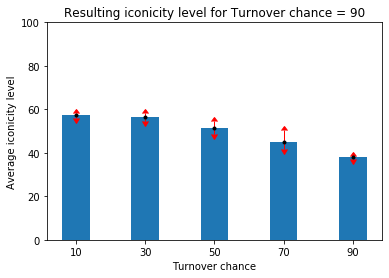

In [10]:
avg, maxi, mini = calculate_average_agent_data_per_iteration(df, chances, nb_iterations)
plot_per_step_data(avg, maxi, mini, chances, "Turnover chance")

### Learning error degree

Next up is the learning error degree; we will test various values that determine the error an agent makes while acquiring the phonological component of a sign.

In [11]:
# define the values of the variable pm and amount of iterations and steps per iteration
errors = [20, 40, 60, 80]
nb_iterations = 10
nb_steps = 100

# define the fixed and variable parameters
fixed_pm = {"width": 10,
            "height": 10,
            "vocab_size": 10,
            "word_length": 5,
            "turnover_chance": 20,
            "turnover_threshold": 10,
            "initial_degree_of_iconicity": 100,
            "l2_radius": 100,
            "l2_replace_chance": 50}
variable_pm = {"learning_error_degree": errors}

# run the batchrunner
df = run_batchrunner(IconicityModel, fixed_pm, variable_pm, nb_iterations, nb_steps)

# print the statistics
print("STATISTICS FOR LEARNING ERROR DEGREE PARAMETER EXPLORATION")
print(" - Possible values: " + str(errors))
print(" - Ran for " + str(nb_iterations) + " iteration(s) and " + str(nb_steps) + " steps per iteration\n")
print(" - Data from running the model for " + str(nb_iterations) + " iteration(s) for each parameter value:")

12it [01:02,  5.21s/it]

STATISTICS FOR LEARNING ERROR DEGREE PARAMETER EXPLORATION
 - Possible values: [20, 40, 60, 80]
 - Ran for 3 iteration(s) and 5 steps per iteration

 - Data from running the model for 3 iteration(s) for each parameter value:


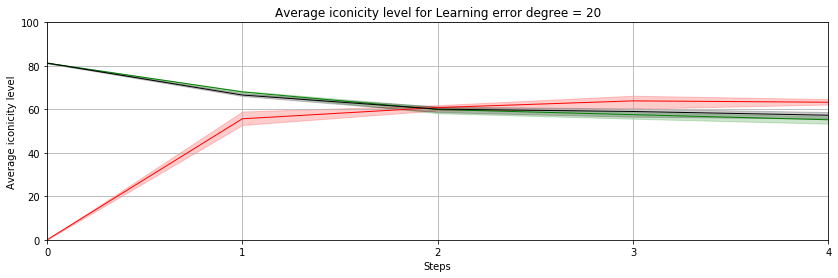

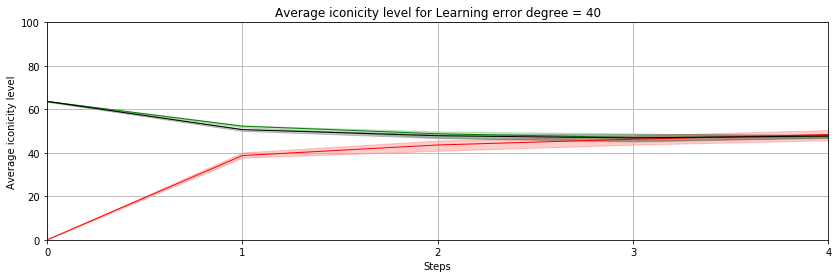

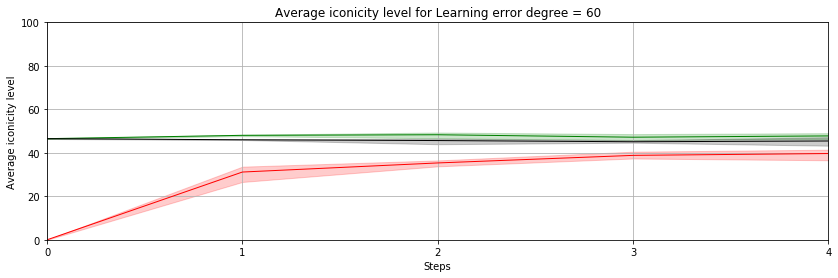

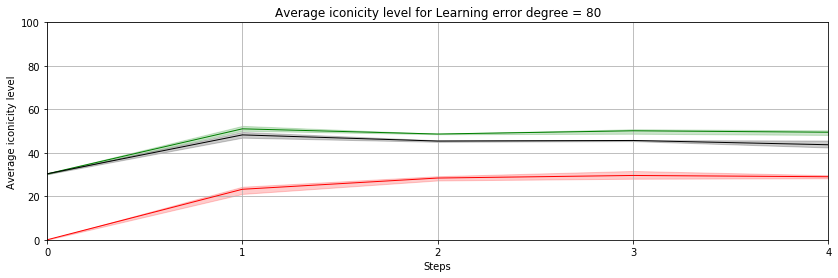

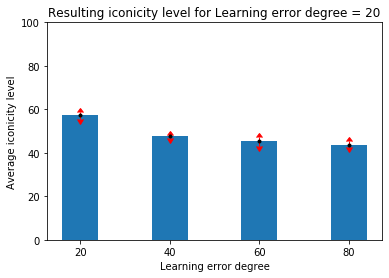

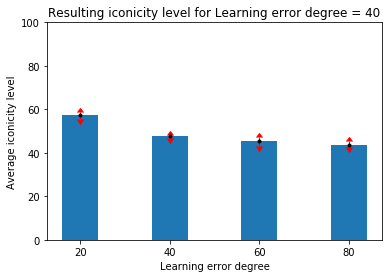

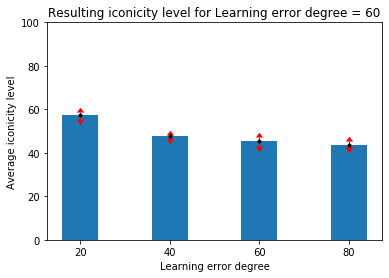

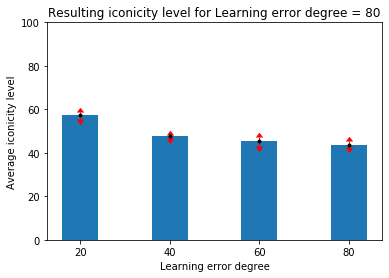

In [12]:
avg, maxi, mini = calculate_average_agent_data_per_iteration(df, errors, nb_iterations)
plot_per_step_data(avg, maxi, mini, errors, "Learning error degree")